In [1]:
# some necessary imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
hourly = pd.read_csv("FremontBridge.csv",index_col='Date',
                    parse_dates=True)

In [10]:
hourly.head()

,northbound,southbound
Date,,
2012-10-03 00:00:00,4,9
2012-10-03 01:00:00,4,6
2012-10-03 02:00:00,1,1
2012-10-03 03:00:00,2,3
2012-10-03 04:00:00,6,1


In [9]:
hourly.columns=  ['northbound','southbound']

In [12]:
hourly['total']= hourly.eval('northbound + southbound')
hourly.head()

,northbound,southbound,total
Date,,,
2012-10-03 00:00:00,4,9,13
2012-10-03 01:00:00,4,6,10
2012-10-03 02:00:00,1,1,2
2012-10-03 03:00:00,2,3,5
2012-10-03 04:00:00,6,1,7


In [13]:
daily = hourly.resample('d','sum')
weekly = daily.resample('w','sum')

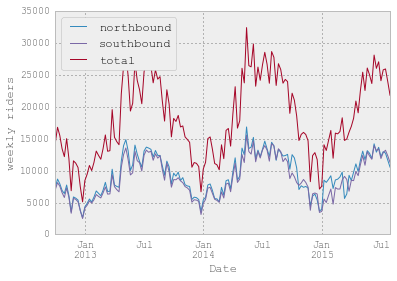

In [14]:
weekly[['northbound','southbound','total']].plot()
plt.ylabel('weekly riders')

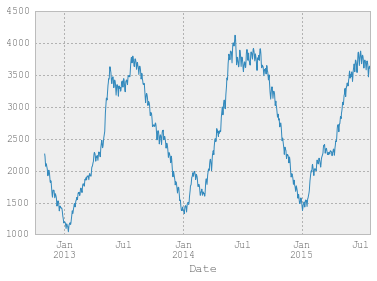

In [15]:
pd.stats.moments.rolling_mean(daily.total,30).plot();

In [16]:
# Define a function which returns the hours of daylight
# given the day of the year, from 0 to 365

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

# add this to our weekly data
weekly['daylight'] = map(hours_of_daylight, weekly.index)
daily['daylight'] = map(hours_of_daylight, daily.index)

In [18]:
weekly.daylight = map(hours_of_daylight,weekly.index)
daily.daylight = map(hours_of_daylight,daily.index)

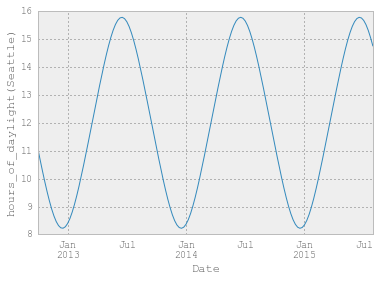

In [20]:
weekly.daylight.plot()
plt.ylabel('hours_of_daylight(Seattle)');

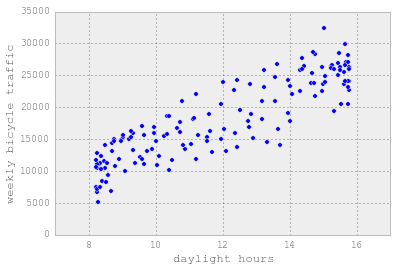

In [21]:
plt.scatter(weekly.daylight,weekly.total)
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

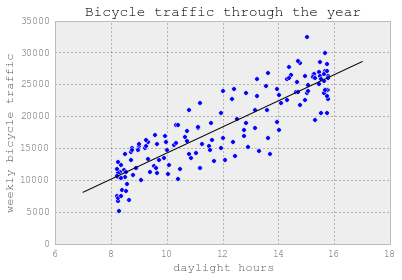

In [22]:
from sklearn.linear_model import LinearRegression

X = weekly[['daylight']].to_dense()
y = weekly['total']
clf = LinearRegression(fit_intercept=True).fit(X, y)

weekly['daylight_trend'] = clf.predict(X)
weekly['daylight_corrected_total'] = weekly['total'] - weekly['daylight_trend'] + weekly['daylight_trend'].mean()

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])
plt.scatter(weekly['daylight'], weekly['total'])
plt.plot(xfit, yfit, '-k')
plt.title("Bicycle traffic through the year")
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

In [24]:
print(clf.coef_[0])

2048.12656429


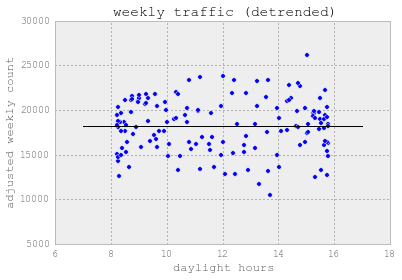

In [25]:
trend = clf.predict(weekly[['daylight']].as_matrix())
plt.scatter(weekly['daylight'], weekly['total'] - trend + np.mean(trend))
plt.plot(xfit, np.mean(trend) + 0 * yfit, '-k')
plt.title("weekly traffic (detrended)")
plt.xlabel('daylight hours')
plt.ylabel('adjusted weekly count');

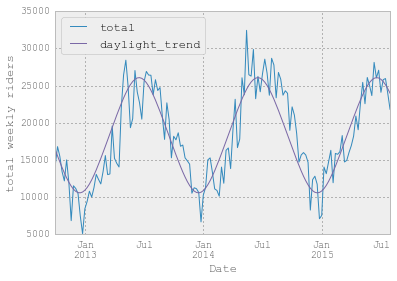

In [26]:
weekly[['total','daylight_trend']].plot()
plt.ylabel('total weekly riders')

root-mean-square about trend: 2959 riders


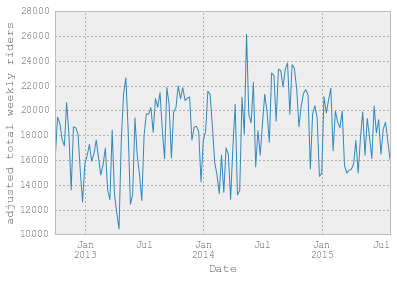

In [27]:
weekly['daylight_corrected_total'].plot()
rms = np.std(weekly['daylight_corrected_total'])
plt.ylabel("adjusted total weekly riders")
print("root-mean-square about trend: {0:.0f} riders".format(rms))